In [1]:
#Set up workspace
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import imageio
import pylab as pl
%matplotlib inline


In [2]:
#OK, let's get the image in grayscale using a "Weighted average" formula referenced here
#https://en.wikipedia.org/wiki/Grayscale#Converting_color_to_grayscale

gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114]) 
#gray_ren = gray(pic)  
#plt.figure( figsize = (10,10))
#plt.imshow(gray_ren, cmap = plt.get_cmap(name = 'gray'))
#plt.show()

In [3]:
#Ok, let's convert the grayscale to a simple black-white: that may help us in observing the 
#"Fractal" structure (and other formal qualities)

def bw_convert(img,thresh):
    bw_pic = img.copy()
    bw_mask = bw_pic[:, :,] < thresh
    bw_pic[bw_mask] = 0
    bw_pic[~bw_mask] = 1
    
    return bw_pic

Ok, let's see if we can compute the fractal dimension of the above. 

In [4]:
#Ok, let's write a formula that can convert from color to bw/binary image
def make_bw(img,thresh=130):
    gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114]) 
    gray_img = gray(img)
    bw_img = bw_convert(gray_img,thresh)
    
    return bw_img

Could we write something that is able to extract/identify forms or patterns?

In [5]:
#Edge Detection
import skimage
import skimage.feature
import skimage.viewer
import sys
from skimage.data import camera
from skimage.filters import roberts, sobel, sobel_h, sobel_v, scharr, scharr_h, scharr_v, prewitt, prewitt_v, prewitt_h

C:\Users\taiwo\Anaconda3\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


In [6]:
from skimage import data, segmentation, filters, color
from skimage.future import graph
from matplotlib import pyplot as plt

def weight_boundary(graph, src, dst, n):
    default = {'weight': 0.0, 'count': 0}

    count_src = graph[src].get(n, default)['count']
    count_dst = graph[dst].get(n, default)['count']

    weight_src = graph[src].get(n, default)['weight']
    weight_dst = graph[dst].get(n, default)['weight']

    count = count_src + count_dst
    return {
        'count': count,
        'weight': (count_src * weight_src + count_dst * weight_dst)/count
    }


def merge_boundary(graph, src, dst):
    """Call back called before merging 2 nodes.

    In this case we don't need to do any computation here.
    """
    pass

In [7]:
def get_edges(image):
    gray_img = gray(image)  
    
    edges = filters.sobel(gray_img)
    labels = segmentation.slic(gray_img, compactness=30, n_segments=10)
    g = graph.rag_boundary(labels, edges)
    labels2 = graph.merge_hierarchical(labels, g, thresh=0.08, rag_copy=False,
                                       in_place_merge=True,
                                       merge_func=merge_boundary,
                                       weight_func=weight_boundary)

    out = color.label2rgb(labels2, gray_img, kind='avg')
    
    # finding all the non-zero pixels
    pixels=[]
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            if i==0:
                pixels.append(0)
            elif j==0:
                pixels.append(0)
            elif i==out.shape[0]-1: ##
                pixels.append(0)
            elif j==out.shape[1]-1: ##
                pixels.append(0)

            elif out[i,j]!=out[i-1,j]:
                pixels.append(1)
            elif out[i,j]!=out[i,j+1]:
                pixels.append(1)

            elif out[i,j]!=out[i+1,j]:
                pixels.append(1)
            elif out[i,j]!=out[i,j+1]:
                pixels.append(1)
            else:
                pixels.append(0)

    pixels_matrix = np.array(pixels).reshape(out.shape)
    
    return pixels_matrix

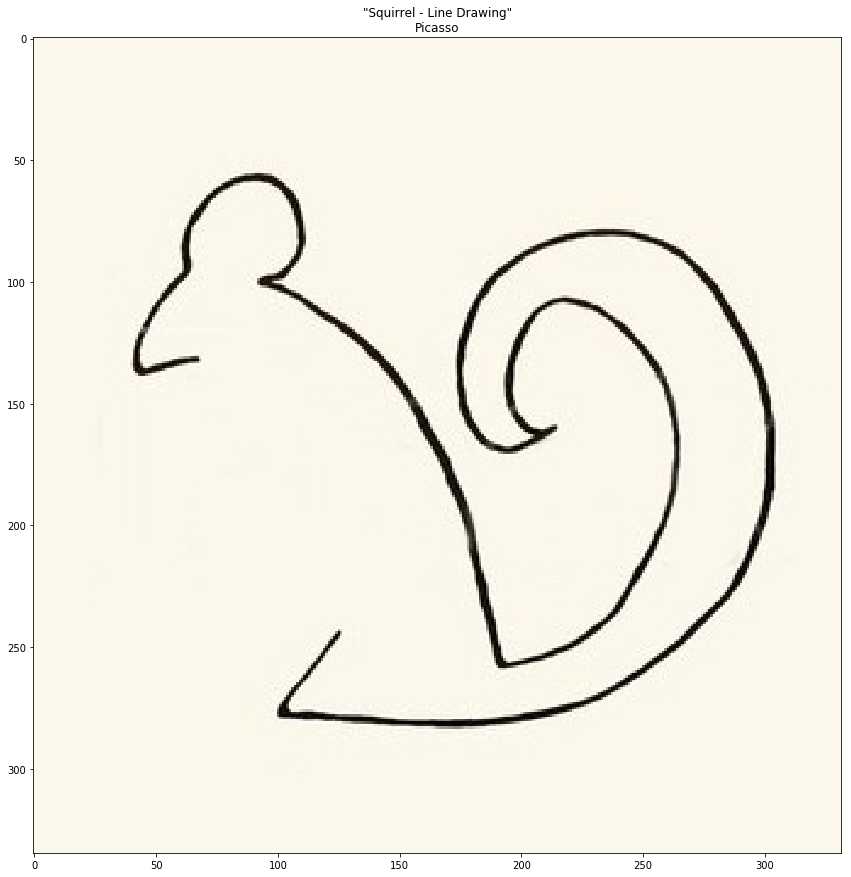

In [8]:
squirrel = imageio.imread('Paintings/squirrel.jpg')
plt.figure(figsize = (15,15))
plt.title('"Squirrel - Line Drawing"\nPicasso')
plt.imshow(squirrel)

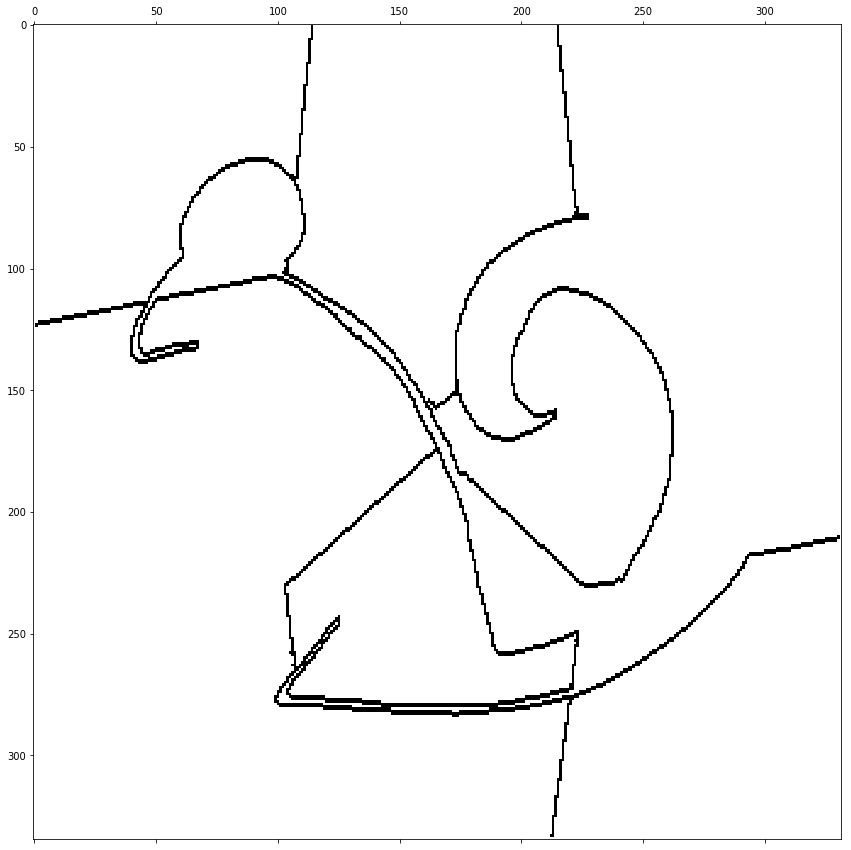

In [9]:
squirrel_edges = get_edges(squirrel)
plt.figure(figsize = (15,15))
plt.spy(squirrel_edges)

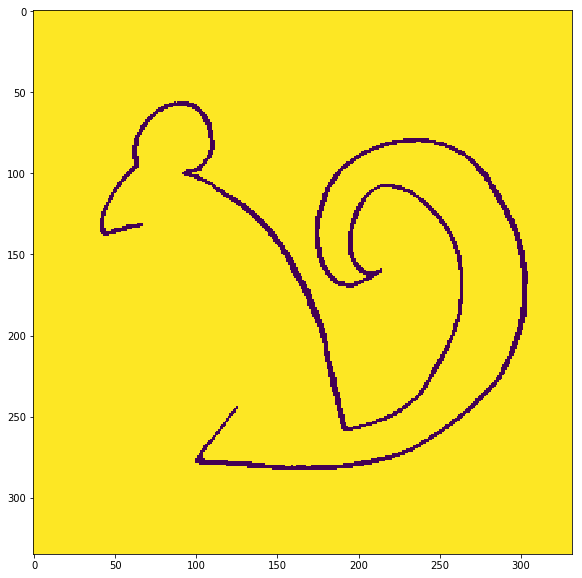

In [10]:
bw_sq = make_bw(squirrel,130)
plt.figure(figsize = (10,10))
plt.imshow(bw_sq)

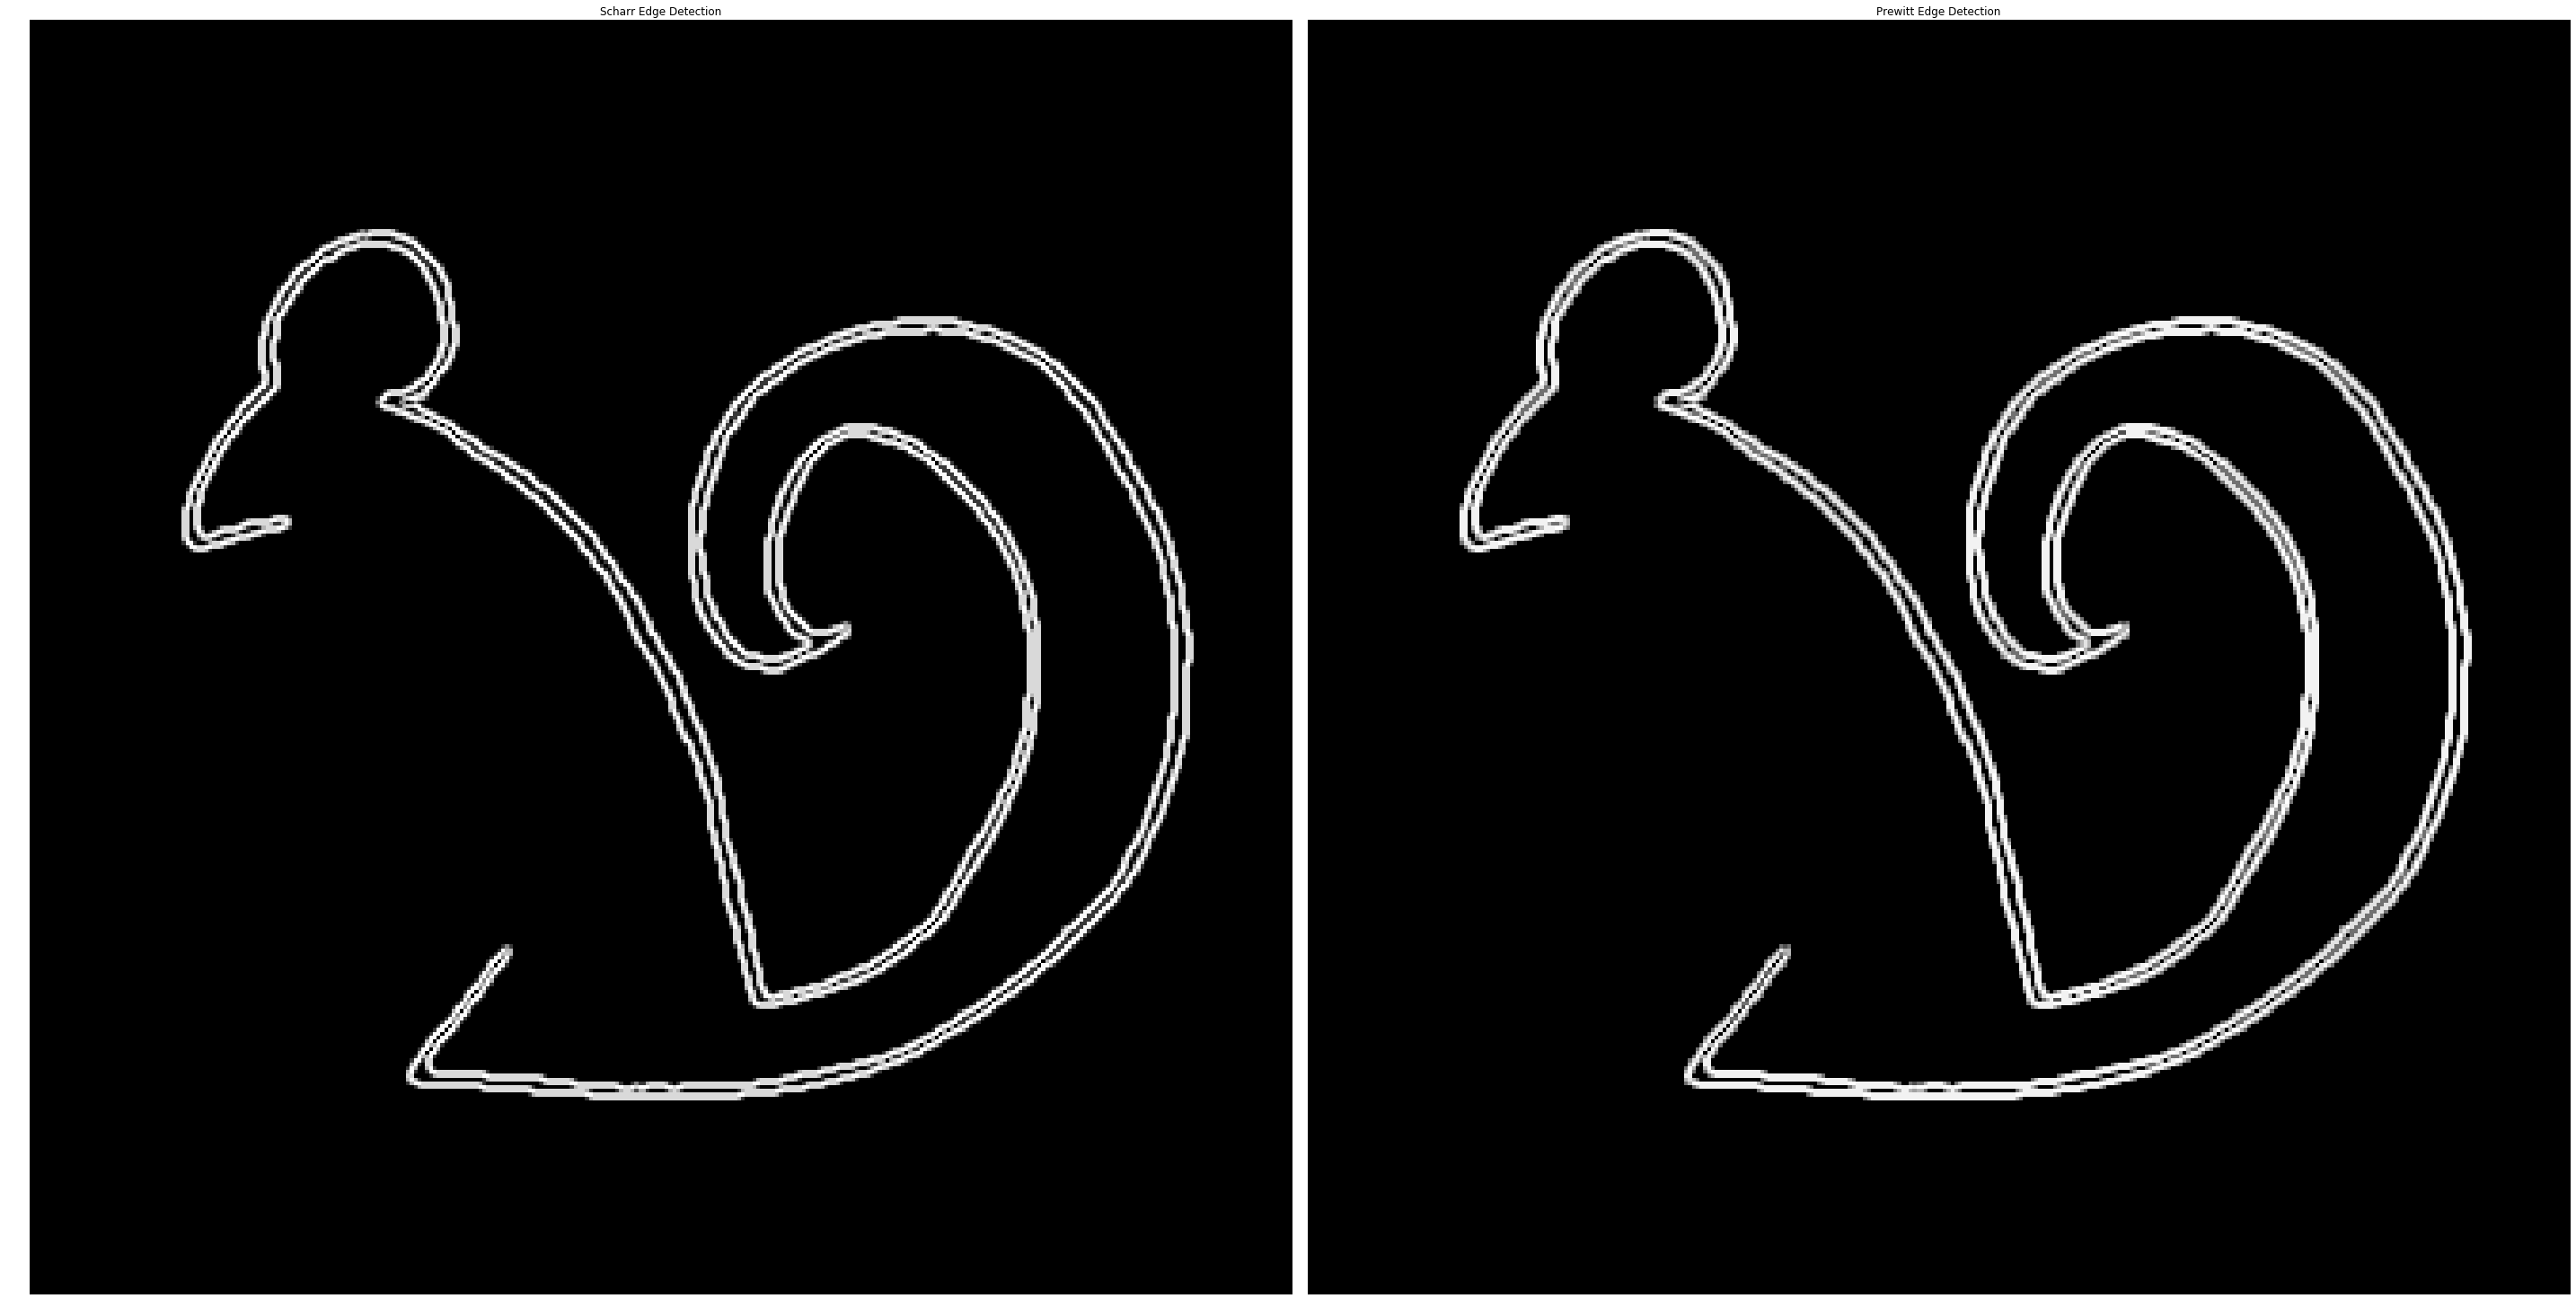

In [11]:
edge_scharr = scharr(bw_sq)
edge_prewitt = prewitt(bw_sq)

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(40,20))

ax[0].imshow(edge_scharr, cmap=plt.cm.gray)
ax[0].set_title('Scharr Edge Detection')

ax[1].imshow(edge_prewitt, cmap=plt.cm.gray)
ax[1].set_title('Prewitt Edge Detection')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

Ok, great! Edge detection using existing Python packages actually works pretty great for Picasso's line drawings. But you need to follow the following steps: 1. convert to BW; 2. convert to binary. 

In [12]:
edge_scharr.shape

(335, 332)

In [13]:
edge_scharr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

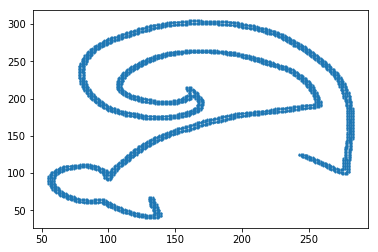

In [14]:
list_of_points = []

for i in range (edge_scharr.shape[0]):
    for j in range (edge_scharr.shape[1]):
        if edge_scharr[i][j]!=0:
            list_of_points.append((i,j))

list_of_points
testList2 = [(elem1, elem2) for elem1, elem2 in list_of_points]
#zip(*testList2)

plt.scatter(*zip(*testList2), s=1)

In [15]:

from skimage.morphology import skeletonize, thin
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert
import imageio
from scipy import misc
from skimage import color
from skimage import measure

#Set up workspace
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import imageio
import pylab as plx

array([283.        , 282.9934212 , 282.94932511, ..., 283.28065618,
       283.12265564, 283.        ])

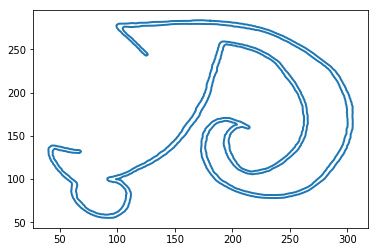

In [16]:
fimg = imageio.imread("Paintings/squirrel.jpg")
gimg = color.colorconv.rgb2grey(fimg)
contours = measure.find_contours(gimg, 0.8)
# print(np.array(contours).shape)
# print(contours)

contours_nd = np.array(contours)

for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

    
contours_nd[0, :, 0]

In [17]:
raw_point_array= contours_nd[0]
import pandas as pd
df = pd.DataFrame(raw_point_array)
len(df)

3177

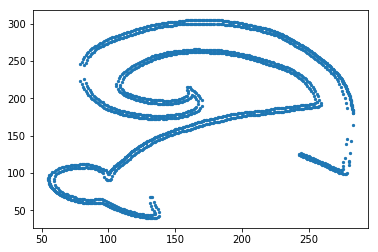

In [40]:

#df_unique = df.drop_duplicates(inplace = False) 
df_unique =df.drop_duplicates(subset=[df.columns[1]], inplace =False)
df_unique_y = df_unique.drop_duplicates(subset=[df_unique.columns[1]], inplace =False) 
uniquified_points = df_unique.values

uniquified_points_zip = [(elem1, elem2) for elem1, elem2 in uniquified_points]
plt.scatter(*zip(*uniquified_points_zip), s=5)
#plt.scatter(*zip(*uniquified_points_zip), s=5)

In [39]:
len(uniquified_points)

1931

In [19]:
len(uniquified_points)

3176

In [20]:

#raw_point_array[i] corresponds to ith point

def check_x_increasing(point1, point2): #point1 and point2 are [x1,y1], [y1,y2]
    if point1[0] < point2[0]:
        return True 
    else:
        return False
    
def process_point_array(raw_point_array):
    output = []
    cutoff_ind = [0]
    increasing_current = check_x_increasing(raw_point_array[0],raw_point_array[1])
    for point_idx in range(len(raw_point_array)): # point = [x_coord, y_coord]
        if point_idx !=len(raw_point_array)-1:
            if increasing_current !=check_x_increasing(raw_point_array[point_idx], raw_point_array[point_idx+1]):
                cutoff_ind.append(point_idx)
                increasing_current = not increasing_current
    cutoff_ind.append(len(raw_point_array)-1) #the last point
    
    for i in range(len(cutoff_ind)-1):
        output.append(raw_point_array[cutoff_ind[i]:cutoff_ind[i+1]+1])
        
    return output



#https://stackoverflow.com/questions/52524919/fourier-series-fit-in-python
#https://stackoverflow.com/questions/31464345/fitting-a-closed-curve-to-a-set-of-points

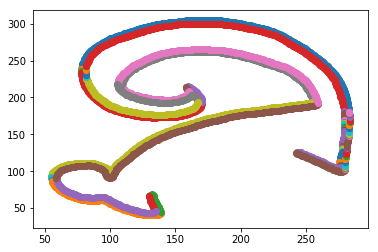

In [100]:
splited = process_point_array(raw_point_array)
for i in range(len(splited)):
    plt.scatter(*zip(*splited[i])) 

In [101]:
len(splited)

67

In [48]:
#splited[ith cut][nth point in the cut][0 or 1 for x or y]

array([283.       , 180.8498625])

In [23]:
from symfit import parameters, variables, sin, cos, Fit
import numpy as np
import matplotlib.pyplot as plt

def fourier_series(x, f, n=0):
    """
    Returns a symbolic fourier series of order `n`.

    :param n: Order of the fourier series.
    :param x: Independent variable
    :param f: Frequency of the fourier series
    """
    # Make the parameter objects for all the terms
    a0, *cos_a = parameters(','.join(['a{}'.format(i) for i in range(0, n + 1)]))
    sin_b = parameters(','.join(['b{}'.format(i) for i in range(1, n + 1)]))
    # Construct the series
    series = a0 + sum(ai * cos(i * f * x) + bi * sin(i * f * x)
                     for i, (ai, bi) in enumerate(zip(cos_a, sin_b), start=1))
    return series

#credit: https://stackoverflow.com/questions/52524919/fourier-series-fit-in-python

In [102]:
splited1 =[splited[0]]
len(splited1)

1

In [96]:
print(model_dict)
for cut in splited1:
    x, y = variables('x, y')
    w, = parameters('w')
    model_dict = {y: fourier_series(x, f=w, n=1)}
    print("lenght of cut",len(cut))
    xdata=[]
    ydata=[]
    for i in range(len(cut)):
            
            xdata.append(cut[i][0])
            ydata.append(cut[i][1])
    #print("x_data: ",xdata)
    fit = Fit(model_dict, x=xdata, y=ydata)
    fit_result = fit.execute()
    y_output = []
    for x_ent in xdata:
        y_output.append(fit_result.params['a0'] + fit_result.params['a1']*math.cos(fit_result.params['w']*x_ent)+ 
                    fit_result.params['a2']*math.cos(2*fit_result.params['w']*x_ent)+
                    fit_result.params['a3']*math.cos(3*fit_result.params['w']*x_ent)+
                    fit_result.params['b1']*math.sin(fit_result.params['w']*x_ent)+
                    fit_result.params['b2']*math.sin(2*fit_result.params['w']*x_ent)+
                    fit_result.params['b3']*math.sin(3*fit_result.params['w']*x_ent))
             
                 
    #print(y_output)            
            #print(fit_result)
            #plt.plt(x_data,y_data)
    #print(fit_result.params)
    #fit.model(x=xdata, **fit_result.params).y : not working; buggy
    plt.plot(xdata, y_output)
    plt.xlim(0,300)
    plt.ylim(0,300)
    plt.show

{y: a0 + a1*cos(w*x) + a2*cos(2*w*x) + a3*cos(3*w*x) + b1*sin(w*x) + b2*sin(2*w*x) + b3*sin(3*w*x)}
lenght of cut 396


KeyError: 'a2'

lenght of cut 396
lenght of cut 3
lenght of cut 4
lenght of cut 175
lenght of cut 34
lenght of cut 8


C:\Users\taiwo\Anaconda3\lib\site-packages\symfit\core\fit.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = rss / dof


lenght of cut 86
lenght of cut 262
lenght of cut 331
lenght of cut 5
lenght of cut 2
lenght of cut 137
lenght of cut 34
lenght of cut 27
lenght of cut 132
lenght of cut 338
lenght of cut 275
lenght of cut 111
lenght of cut 156
lenght of cut 3
lenght of cut 8


C:\Users\taiwo\Anaconda3\lib\site-packages\symfit\core\fit.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = rss / dof


lenght of cut 6
lenght of cut 2
lenght of cut 376
lenght of cut 3
lenght of cut 11
lenght of cut 3
lenght of cut 2
lenght of cut 3
lenght of cut 5
lenght of cut 2
lenght of cut 2
lenght of cut 3
lenght of cut 2
lenght of cut 24
lenght of cut 3
lenght of cut 2
lenght of cut 2
lenght of cut 4
lenght of cut 2
lenght of cut 17
lenght of cut 6
lenght of cut 2
lenght of cut 2
lenght of cut 60
lenght of cut 67
lenght of cut 2
lenght of cut 3
lenght of cut 2
lenght of cut 8


C:\Users\taiwo\Anaconda3\lib\site-packages\symfit\core\fit.py:263: RuntimeWarning: divide by zero encountered in double_scalars
  s2 = rss / dof


lenght of cut 5
lenght of cut 6
lenght of cut 4
lenght of cut 11
lenght of cut 2
lenght of cut 17
lenght of cut 2
lenght of cut 3
lenght of cut 3
lenght of cut 6
lenght of cut 5
lenght of cut 7
lenght of cut 2
lenght of cut 7
lenght of cut 5
lenght of cut 2
lenght of cut 3


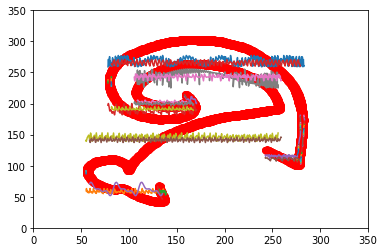

In [131]:

#print(model_dict)
for cut in splited:
    x, y = variables('x, y')
    w, = parameters('w')
    model_dict = {y: fourier_series(x, f=w, n=3)}
    print("lenght of cut",len(cut))
    xdata=[]
    ydata=[]
    for i in range(len(cut)):
            
            xdata.append(cut[i][0])
            ydata.append(cut[i][1])
    #print("x_data: ",xdata)
    fit = Fit(model_dict, x=xdata, y=ydata)
    fit_result = fit.execute()
             
    plt.scatter(*zip(*cut), c = 'red')             
    #print(y_output)            
            #print(fit_result)
            #plt.plt(x_data,y_data)
    #print(fit_result.params)
    # : not working; buggy
    xdata=np.array(xdata)
    
    plt.plot(xdata, fit.model(x=xdata, **fit_result.params).y)
    plt.xlim(0,350)
    plt.ylim(0,350)
    plt.show

<class 'numpy.ndarray'>


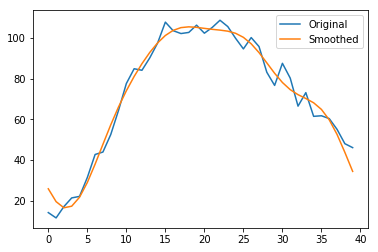

In [144]:
import numpy as np

x = np.arange(40)
y = np.log(x + 1) * np.exp(-x/8.) * x**2 + np.random.random(40) * 15
print(type(y))
rft = np.fft.rfft(y)
rft[5:] = 0   # Note, rft.shape = 21
y_smooth = np.fft.irfft(rft)

plt.plot(x, y, label='Original')
plt.plot(x, y_smooth, label='Smoothed')
plt.legend(loc=0)
plt.show()

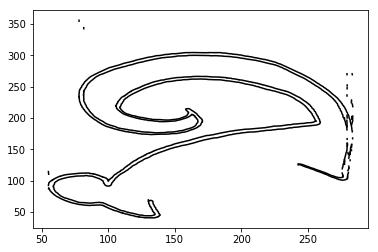

In [171]:
splited2 = [splited[3]]
#print(splited2)
for cut in splited:
    #print(cut)
    #print("round")
    xdata=[]
    ydata=[]
    #print(len(cut))
    for i in range(len(cut)):
            
        xdata.append(cut[i][0])
        ydata.append(cut[i][1])

    x = xdata
    y = ydata
    #print(len(xdata))
    #print(len(ydata))
    rft = np.fft.rfft(y)
    #print((rft))
    #rft[5:] = 0   # Note, rft.shape = 21
    y_smooth = np.fft.irfft(rft)
    #print((y_smooth))
    #plt.plot(x, y, label='Original', marker = 'o', c = 'red')
    try:
        plt.plot(x, y_smooth, c = 'black')
    except:
        plt.plot(x[:-1],y_smooth, c = 'black')
    #plt.legend(loc=0)
plt.show()

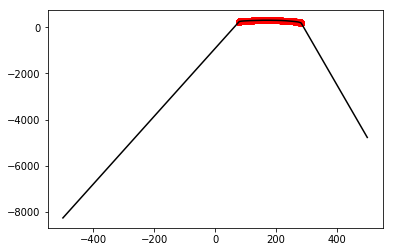

In [130]:
for cut in splited1:
    xdata=[]
    ydata=[]
    for i in range(len(cut)):
            
        xdata.append(cut[i][0])
        ydata.append(cut[i][1])
    


    plt.scatter(xdata,ydata, c = "r", label='Data')

    #f = interp1d(xdata,ydata,kind='cubic')
    x = np.linspace (-500, 500, 10000)
    f1 = interp1d(xdata, ydata,axis=0, fill_value="extrapolate")
    plt.plot(x,f1(x),c = "black")
   

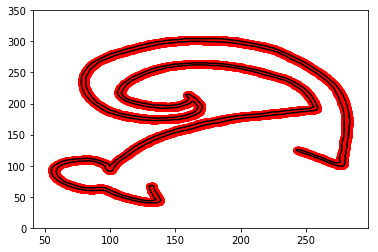

In [133]:

from scipy.interpolate import interp1d
for cut in splited:
    xdata=[]
    ydata=[]
    for i in range(len(cut)):
            
        xdata.append(cut[i][0])
        ydata.append(cut[i][1])
    


    plt.scatter(xdata,ydata, c = "r", label='Data')

    #f = interp1d(xdata,ydata,kind='cubic')
    f1 = interp1d(xdata, ydata,axis=0, fill_value="extrapolate")
    plt.plot(xdata,f1(xdata),c = "black")
    plt.ylim(0,350)
    
    

    

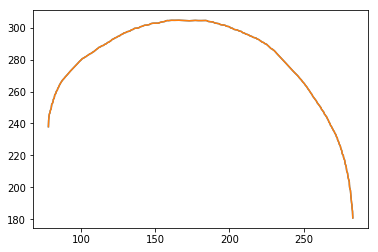

In [137]:
def lagrange(x,points_x,points_y):
    Lm=0
    for k in range(points_x.size):
        xc=points_x[k]
        Li=1
        for i in range(points_x.size):
            if i != k:
                Li *= (x-points_x[i]) / (points_x[k] - points_x[i])
        Lm += points_y[k] * Li
    return Lm


for cut in splited1:
    xdata=[]
    ydata=[]
    for i in range(len(cut)):
            
        xdata.append(cut[i][0])
        ydata.append(cut[i][1])
    x=xdata
    points_x = np.array(xdata)
    points_y = np.array(ydata)
    y=np.array([lagrange(q,points_x,points_y) for q in x])
    

    plt.figure()
    plt.plot(x,y,label='f(x)')
    plt.plot(x,points_y, label='$p_3(x)$')


Parameter Value        Standard Deviation
a0        -5.590192e+04 nan
a1        5.441335e+04 3.121444e+07
a2        2.864466e+04 1.201433e+08
a3        -2.715609e+04 4.445245e+07
b1        4.669591e+04 1.519663e+10
b2        2.031890e+04 1.227728e+10
b3        1.323160e+04 3.107831e+09
w         9.698841e-05 2.548681e-05
Status message         Desired error not necessarily achieved due to precision loss.
Number of iterations   1316
Objective              <symfit.core.objectives.LeastSquares object at 0x000001BA2BFF3DD8>
Minimizer              <symfit.core.minimizers.BFGS object at 0x000001BA2BFF3DA0>

Goodness of fit qualifiers:
chi_squared            4933.547360374143
objective_value        2466.7736801870715
r_squared              0.8404484027218844


C:\Users\taiwo\Anaconda3\lib\site-packages\symfit\core\fit_results.py:114: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.variance(param))


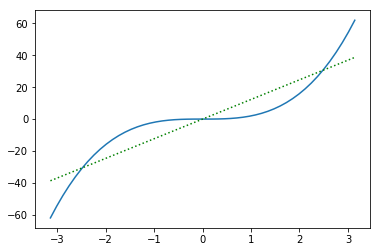

In [94]:
# Make step function data
xdata = np.linspace(-np.pi, np.pi)
ydata = 2* xdata **3
# Define a Fit object for this model and data
fit = Fit(model_dict, x=xdata, y=ydata)
fit_result = fit.execute()
print(fit_result)

# Plot the result
plt.plot(xdata, ydata)
plt.plot(xdata, fit.model(x=xdata, **fit_result.params).y, color='green', ls=':')

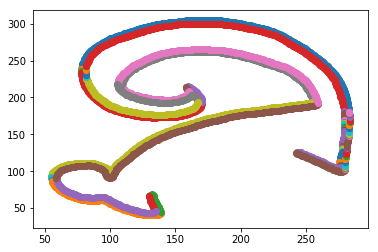

In [79]:
splited = process_point_array(raw_point_array)
for i in range(len(splited)):
    plt.scatter(*zip(*splited[i]))

In [ ]:
xdata = np.linspace(-np.pi, np.pi)
ydata = np.zeros_like(xdata)
ydata[xdata > 0] = 1
# Define a Fit object for this model and data
fit = Fit(model_dict, x=xdata, y=ydata)
fit_result = fit.execute()
print(fit_result)

# Plot the result
plt.plot(xdata, ydata)
plt.plot(xdata, fit.model(x=xdata, **fit_result.params).y, color='green', ls=':')

In [24]:
squirrel = imageio.imread('paintings/squirrel.jpg') 
squirrel_bw = invert(make_bw(squirrel))
skeleton = invert(thin(squirrel_bw))


In [25]:

contours_sk = measure.find_contours(skeleton, 0.8)
contours_nd_sk = np.array(contours_sk)
contours_nd_sk

array([[[282. , 170.8],
        [281.8, 171. ],
        [281.8, 172. ],
        ...,
        [282.8, 169. ],
        [282.8, 170. ],
        [282. , 170.8]]])

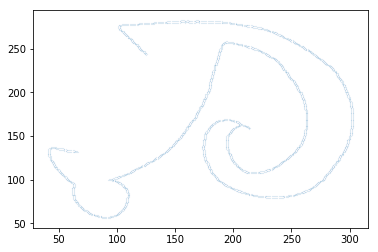

In [26]:

for n, contour in enumerate(contours_sk):
    plt.scatter(contour[:, 1], contour[:, 0], marker = ".", s=0.01)

In [27]:
contours_nd_sk[0]

array([[282. , 170.8],
       [281.8, 171. ],
       [281.8, 172. ],
       ...,
       [282.8, 169. ],
       [282.8, 170. ],
       [282. , 170.8]])

In [28]:
splited_sk = process_point_array(contours_nd_sk[0])
splited_sk

[array([[282. , 170.8],
        [281.8, 171. ],
        [281.8, 172. ],
        [281.8, 173. ],
        [281.8, 174. ],
        [281.8, 175. ],
        [281.8, 176. ],
        [281.8, 177. ],
        [281.8, 178. ],
        [281.8, 179. ],
        [281.8, 180. ],
        [281.8, 181. ],
        [281.8, 182. ],
        [281.8, 183. ],
        [281.8, 184. ],
        [281.8, 185. ],
        [281.8, 186. ],
        [281.8, 187. ],
        [281.8, 188. ],
        [281.8, 189. ],
        [281.8, 190. ],
        [281. , 190.8],
        [280.8, 191. ],
        [280.8, 192. ],
        [280.8, 193. ],
        [280.8, 194. ],
        [280.8, 195. ],
        [280.8, 196. ],
        [280.8, 197. ],
        [280. , 197.8],
        [279.8, 198. ],
        [279.8, 199. ],
        [279.8, 200. ],
        [279.8, 201. ],
        [279.8, 202. ],
        [279. , 202.8],
        [278.8, 203. ],
        [278.8, 204. ],
        [278.8, 205. ],
        [278.8, 206. ],
        [278.8, 207. ],
        [278. , 

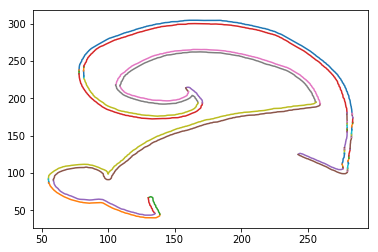

In [29]:
for i in range(len(splited)):
    plt.plot(*zip(*splited[i])) 

In [30]:
#alternating between  grab, skip, grap skip